# Illuminating Mainstream Media Political Bias through Text Mining
__Aaron Carr, Azucena Faus, and Dave Friesen - ADS-509-01-SU23__

In [1]:
__author__ = 'Aaron Carr, Azucena Faus, Dave Friesen'
__email__ = 'acarr@sandiego.edu, afaus@sandiego.edu, dfriesen@sandiego.edu'
__version__ = '1.0'
__date__ = 'June 2023'

## Setup

In [2]:
# Import basic and data access libraries
import numpy as np
import pandas as pd
from profiler import profile, profile_cat

# Import pre-processing, model and performance evaluation libraries
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestCentroid
from model_process import ModelProcess

from transformers import pipeline as tpipeline

# Import lexicons
#import nltk
#nltk.download('opinion_lexicon')
from nltk.corpus import opinion_lexicon

# Import visualization libraries
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

# Import utility libraries
import math
from collections import Counter, defaultdict
from tqdm import tqdm; tqdm.pandas()

In [3]:
# Set basic np, pd, and plt output defaults (keeping this code 'clean')
%run -i 'defaults.py'

## Data Ingestion

In [4]:
# Instantiate and confirm master dataframe
master_df = pd.read_csv('../data/master.csv')
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4509 entries, 0 to 4508
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   source_name   4509 non-null   object
 1   author        4472 non-null   object
 2   title         4509 non-null   object
 3   url           4509 non-null   object
 4   publish_date  4509 non-null   object
 5   content       1158 non-null   object
 6   article_text  4508 non-null   object
dtypes: object(7)
memory usage: 246.7+ KB


In [5]:
# "Blanket" label data based on purported source leaning
target_cls_col = 'lean'

def assign_lean(source_name):
    if source_name == 'Breitbart News' or source_name == 'Fox News':
        return 'right'
    elif source_name == 'CNN' or source_name == 'The Washington Post':
        return 'left'
    else:
        return np.nan
master_df[target_cls_col] = master_df['source_name'].apply(lambda x: assign_lean(x))

## Tokenization and Cleaning

In [6]:
# Stopword removal function, with related initialization
from nltk.corpus import stopwords
sw = stopwords.words('english')
def remove_stop(tokens):
    filtered_tokens = [word for word in tokens if word not in sw]
    return(filtered_tokens)

# Token join back to string
def join_tokens(tokens):
    return ' '.join(tokens)

# Tokenizing function
def tokenize(text):
    return(text.split())  # Tokenize on white space

# Emoji-to-text conversion function
import emoji
def convert_emojis(text):
#    return emoji.demojize(text)
    return emoji.demojize(text).replace('_', ' ')

# Contains-emojis function, with related initialization
all_language_emojis = set()
for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country]:
        all_language_emojis.add(em)
def contains_emoji(s):
    s = str(s)
    emojis = [ch for ch in s if ch in all_language_emojis]
    return(len(emojis) > 0)

# Punctuation removal function, with related initialization
from string import punctuation
tw_punct = set(punctuation + '’') - {'#'}
def remove_punct(text, punct_set=tw_punct):
    return(''.join([ch for ch in text if ch not in punct_set]))

# Preparation (pipeline) function
def prepare(text, pipeline):
    tokens = str(text)
    for transform in pipeline:
        tokens = transform(tokens)
    return(tokens)

In [7]:
# Set pipeline
pipeline = [str.lower, remove_punct, convert_emojis, tokenize, remove_stop]

# Clean and tokenize master dataframe
master_df['article_tokens'] = master_df['article_text'].progress_apply(lambda x: prepare(x, pipeline))
master_df['article_text_tokenized'] = master_df['article_tokens'].progress_apply(lambda x: join_tokens(x))
print(master_df['article_tokens'])
print(master_df['article_text_tokenized'])

100%|████████████████████████████████████| 4509/4509 [00:00<00:00, 84173.57it/s]

0       [travelers, alabama, driving, interstate, 65, ...
1       [federal, prosecutor, may, nearing, decision, ...
2       [federal, appeals, court, tuesday, cleared, wa...
3       [speaking, orlando, november, 2015, republican...
4                                                   [nan]
                              ...                        
4504    [germanys, populist, alternative, germany, afd...
4505    [president, bidens, justice, department, seemi...
4506    [incumbent, turkish, president, recep, tayyip,...
4507    [throughout, month, may, farleft, cnn, attract...
4508    [disney, known, fighting, antigrooming, legisl...
Name: article_tokens, Length: 4509, dtype: object
0       travelers alabama driving interstate 65 partie...
1       federal prosecutor may nearing decision whethe...
2       federal appeals court tuesday cleared way drug...
3       speaking orlando november 2015 republican pres...
4                                                     nan
                      

## Descriptive Stats

In [8]:
# Descriptive stats function
def descriptive_stats(tokens, num_tokens=5, verbose=False):
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))  # set() creates unordered set of unique elements
    num_characters = sum(len(token) for token in tokens)  # Finds characters sans spaces
    lexical_diversity = num_unique_tokens / num_tokens
    
    if verbose:
        print(f'There are {num_tokens} tokens in the data.')
        print(f'There are {num_unique_tokens} unique tokens in the data.')
        print(f'There are {num_characters} characters in the data.')
        print(f'The lexical diversity is {lexical_diversity:.3f} in the data.')
    
    return([num_tokens, num_unique_tokens, lexical_diversity, num_characters])

In [9]:
# Descriptive stats across all sources
descriptive_stats([token for sublist in master_df['article_tokens'] for token in sublist])

[1977106, 84569, 0.0427741355294051, 12724251]

In [10]:
# Standard dataframe profile for confirmation
profile(master_df)

100%|██████████████████████████████████| 4509/4509 [00:00<00:00, 1218014.86it/s]


,Dtype,count,unique,na,na%,mean,std,min,max,skew(>=3),<v0.01,VIF(>=10),examples
source_name,object,4509.0,4.0,,,,,,,,,,Fox News__Breitbart
author,object,4472.0,956.0,37.0,0.8,,,,,,,,Lawrence Richard__Jo
title,object,4509.0,4509.0,,,,,,,,,,Texas legislature's
url,object,4509.0,4509.0,,,,,,,,,,https://www.foxnews.
publish_date,object,4509.0,4487.0,,,,,,,,,,2023-05-30T06:00:33Z
content,object,1158.0,1158.0,3351.0,74.3,,,,,,,,nan__nan__nan__nan__
article_text,object,4508.0,4508.0,1.0,,,,,,,,,Texas Gov. Greg Abbo
lean,object,4509.0,2.0,,,,,,,,,,right__right__right_
article_tokens,object,1977106.0,84569.0,,,,,,,,,,"['texas', 'gov', 'gr"
article_text_tokenized,object,4509.0,4509.0,,,,,,,,,,texas gov greg abbot


In [11]:
# Descriptive stats aggregating function
def aggregate_and_describe(group):
    aggregate_tokens = [token for sublist in group['article_tokens'].tolist() for token in sublist]
    return descriptive_stats(aggregate_tokens)

# Aggregate descriptive stats by source; convert to dataframe; sort and output
grouped_stats = master_df.groupby('source_name').apply(aggregate_and_describe)
grouped_stats_df = pd.DataFrame(grouped_stats.tolist(), index=grouped_stats.index,
                                columns=['num_tokens', 'num_unique_tokens', 'lexical_diversity', 'num_characters'])
grouped_stats_df = grouped_stats_df.sort_index(ascending=False)
print(grouped_stats_df)

                     num_tokens  num_unique_tokens  lexical_diversity  num_characters
source_name                                                                          
The Washington Post    366707          32341              0.09             2370171   
Fox News               828739          47097              0.06             5326935   
CNN                    409422          34724              0.08             2628951   
Breitbart News         372238          36815              0.10             2398194   


## Word Cloud

In [12]:
# Word cloud function
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(font_path='/Library/Fonts/Arial.ttf',
                   width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # Convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    plt.show()
    
# Word count function counter
def count_words(df, column='article_tokens', preprocess=None, min_freq=2):
    # Process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # Create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # Transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

Wordcloud for source: Breitbart News


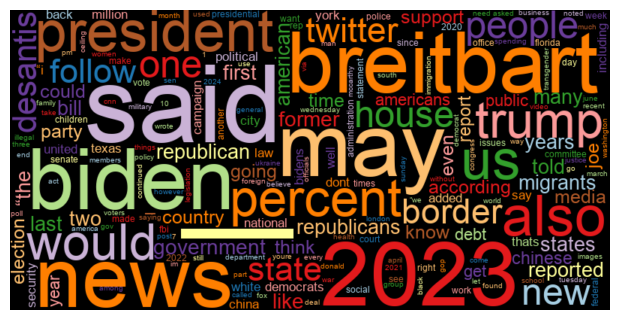

Wordcloud for source: CNN


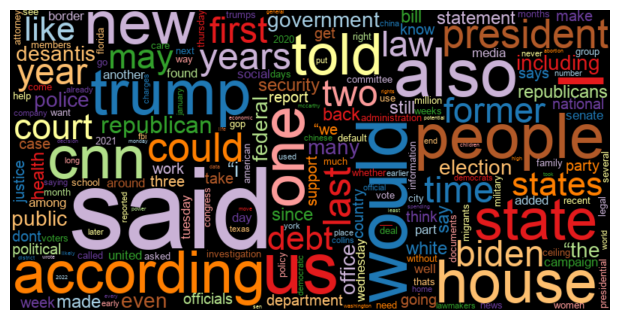

Wordcloud for source: Fox News


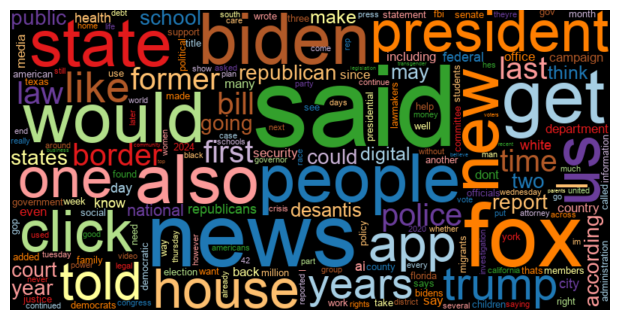

Wordcloud for source: The Washington Post


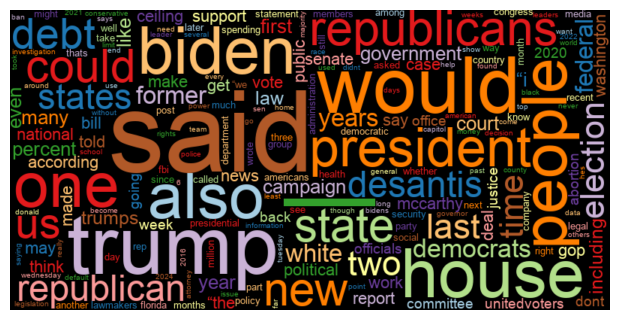

In [13]:
# Iterate and produce word cloud by source
for name, group in master_df.groupby('source_name'):
    print(f"Wordcloud for source: {name}")
    wordcloud(count_words(group)['freq'].to_dict())

## Partition Data

In [14]:
# Set splits
train_ratio = 0.7; val_ratio = 0.20; test_ratio = 0.10

# Split and profile
train_df, test_df = train_test_split(master_df, test_size=1-train_ratio,
                                     random_state=42, stratify=master_df[target_cls_col])
val_df, test_df = train_test_split(test_df, test_size=test_ratio/(test_ratio+val_ratio),
                                   random_state=42, stratify=test_df[target_cls_col])
profile_cat(train_df, [target_cls_col])


lean - 
right 71.17
 left 28.83


## Topic Modeling

In [15]:
# Topic summarization function, from BTAP repo
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1]  # invert sort order

        print('\nTopic %02d' % topic, end=':')
            
        out = []
        for i in range(0, no_top_words):
            out.append(' %s (%2.2f)' % (features[largest[i]], abs(words[largest[i]]*100.0/total)))
        print(';'.join(out), end='')

Topic modeling for source: Breitbart News

Topic 00: percent (5.31); desantis (2.53); trump (2.50); news (1.30); president (1.29)
Topic 01: biden (2.85); border (1.88); house (1.82); migrants (1.29); debt (1.23)
Topic 02: chinese (0.98); people (0.97); government (0.94); china (0.94); may (0.89)
Topic 03: 2023 (1.45); women (1.06); children (1.05); may (1.02); news (0.95)
Topic 04: trump (2.19); president (1.46); think (1.27); thats (1.14); people (1.03)



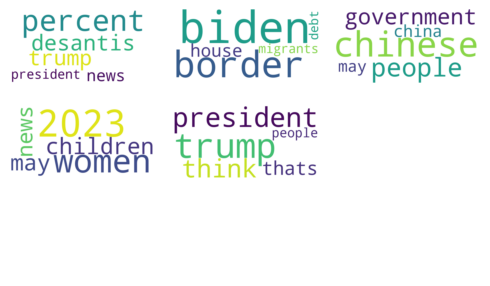

Topic modeling for source: CNN

Topic 00: people (1.18); health (0.99); new (0.98); one (0.77); like (0.73)
Topic 01: us (1.97); government (0.81); china (0.71); chinese (0.65); security (0.64)
Topic 02: police (1.67); according (1.33); cnn (1.17); told (1.02); people (0.79)
Topic 03: trump (2.55); desantis (1.70); former (1.29); president (1.16); court (1.08)
Topic 04: house (2.23); debt (1.78); would (1.68); biden (1.12); bill (1.12)



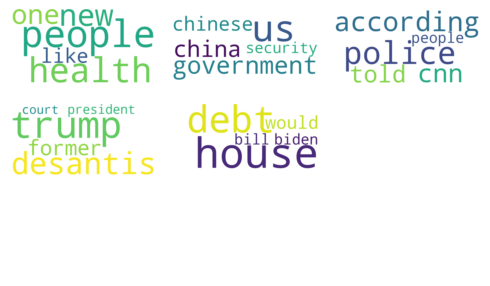

Topic modeling for source: Fox News

Topic 00: ai (1.14); people (1.09); also (0.85); us (0.80); like (0.77)
Topic 01: trump (2.19); president (1.75); desantis (1.59); former (1.31); campaign (1.06)
Topic 02: biden (2.87); house (2.38); president (1.46); debt (1.14); fbi (1.12)
Topic 03: border (2.02); state (1.98); school (1.41); law (1.38); migrants (1.21)
Topic 04: police (1.77); according (0.92); told (0.90); two (0.79); one (0.78)



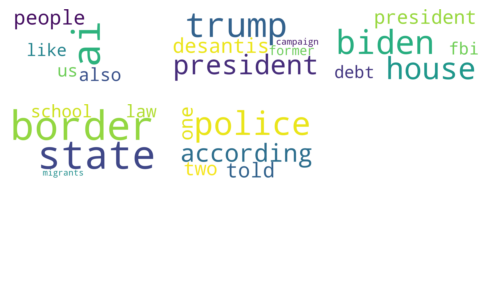

Topic modeling for source: The Washington Post

Topic 00: state (1.91); abortion (1.39); republicans (0.94); bill (0.84); ban (0.81)
Topic 01: trump (1.31); court (0.92); election (0.76); case (0.74); justice (0.72)
Topic 02: trump (3.52); desantis (1.91); president (1.06); trumps (0.85); election (0.83)
Topic 03: people (1.09); states (0.68); new (0.63); us (0.56); health (0.54)
Topic 04: house (2.33); debt (2.05); biden (1.77); republicans (1.29); mccarthy (1.19)



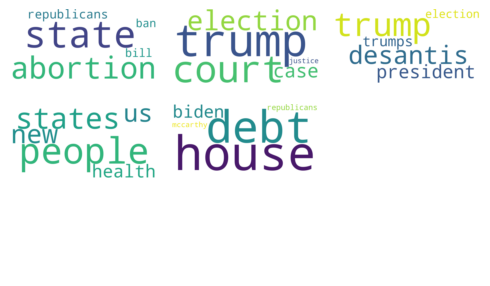

In [16]:
# Model topics by source
for source_name, group in train_df.groupby('source_name'):
    print(f'Topic modeling for source: {source_name}')
    
    # Transform article tokens into bag-of-words document-term sparse matrix
    count_vectorizer = CountVectorizer(min_df=0.05, max_df=0.75)
    count_vectors = count_vectorizer.fit_transform(group['article_text_tokenized'])
#    print('Vector shape:', count_vectors.shape)

    lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
    W_lda_matrix = lda_model.fit_transform(count_vectors)
    H_lda_matrix = lda_model.components_

    display_topics(lda_model, count_vectorizer.get_feature_names_out())
    print('\n')
    
    # Now plot
    num_topics = H_lda_matrix.shape[0]
    words = count_vectorizer.get_feature_names_out()

    # Determine grid size
    grid_size = math.ceil(math.sqrt(num_topics))

    fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 3))

    # Ensure 1-D array to easily index into subplot grid
    axs = axs.flatten()

    for topic_idx, topic in enumerate(H_lda_matrix):
        # Create dataframe for current topic and sort by importance
        topic_df = pd.DataFrame({'word': words, 'importance': topic})
        topic_df = topic_df.sort_values('importance', ascending=False)

        # Get top 5 words of topic and create word cloud
        top_words_dict = {row['word']: row['importance'] for idx, row in topic_df.head(5).iterrows()}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict)

        axs[topic_idx].imshow(wordcloud, interpolation='bilinear')
        axs[topic_idx].axis('off')
    #    axs[topic_idx].set_title(f"Topic #{topic_idx+1}", fontsize=20)

    # Turn off unused subplots
    for idx in range(num_topics, len(axs)):
        axs[idx].axis('off')

    plt.tight_layout()
    plt.show()

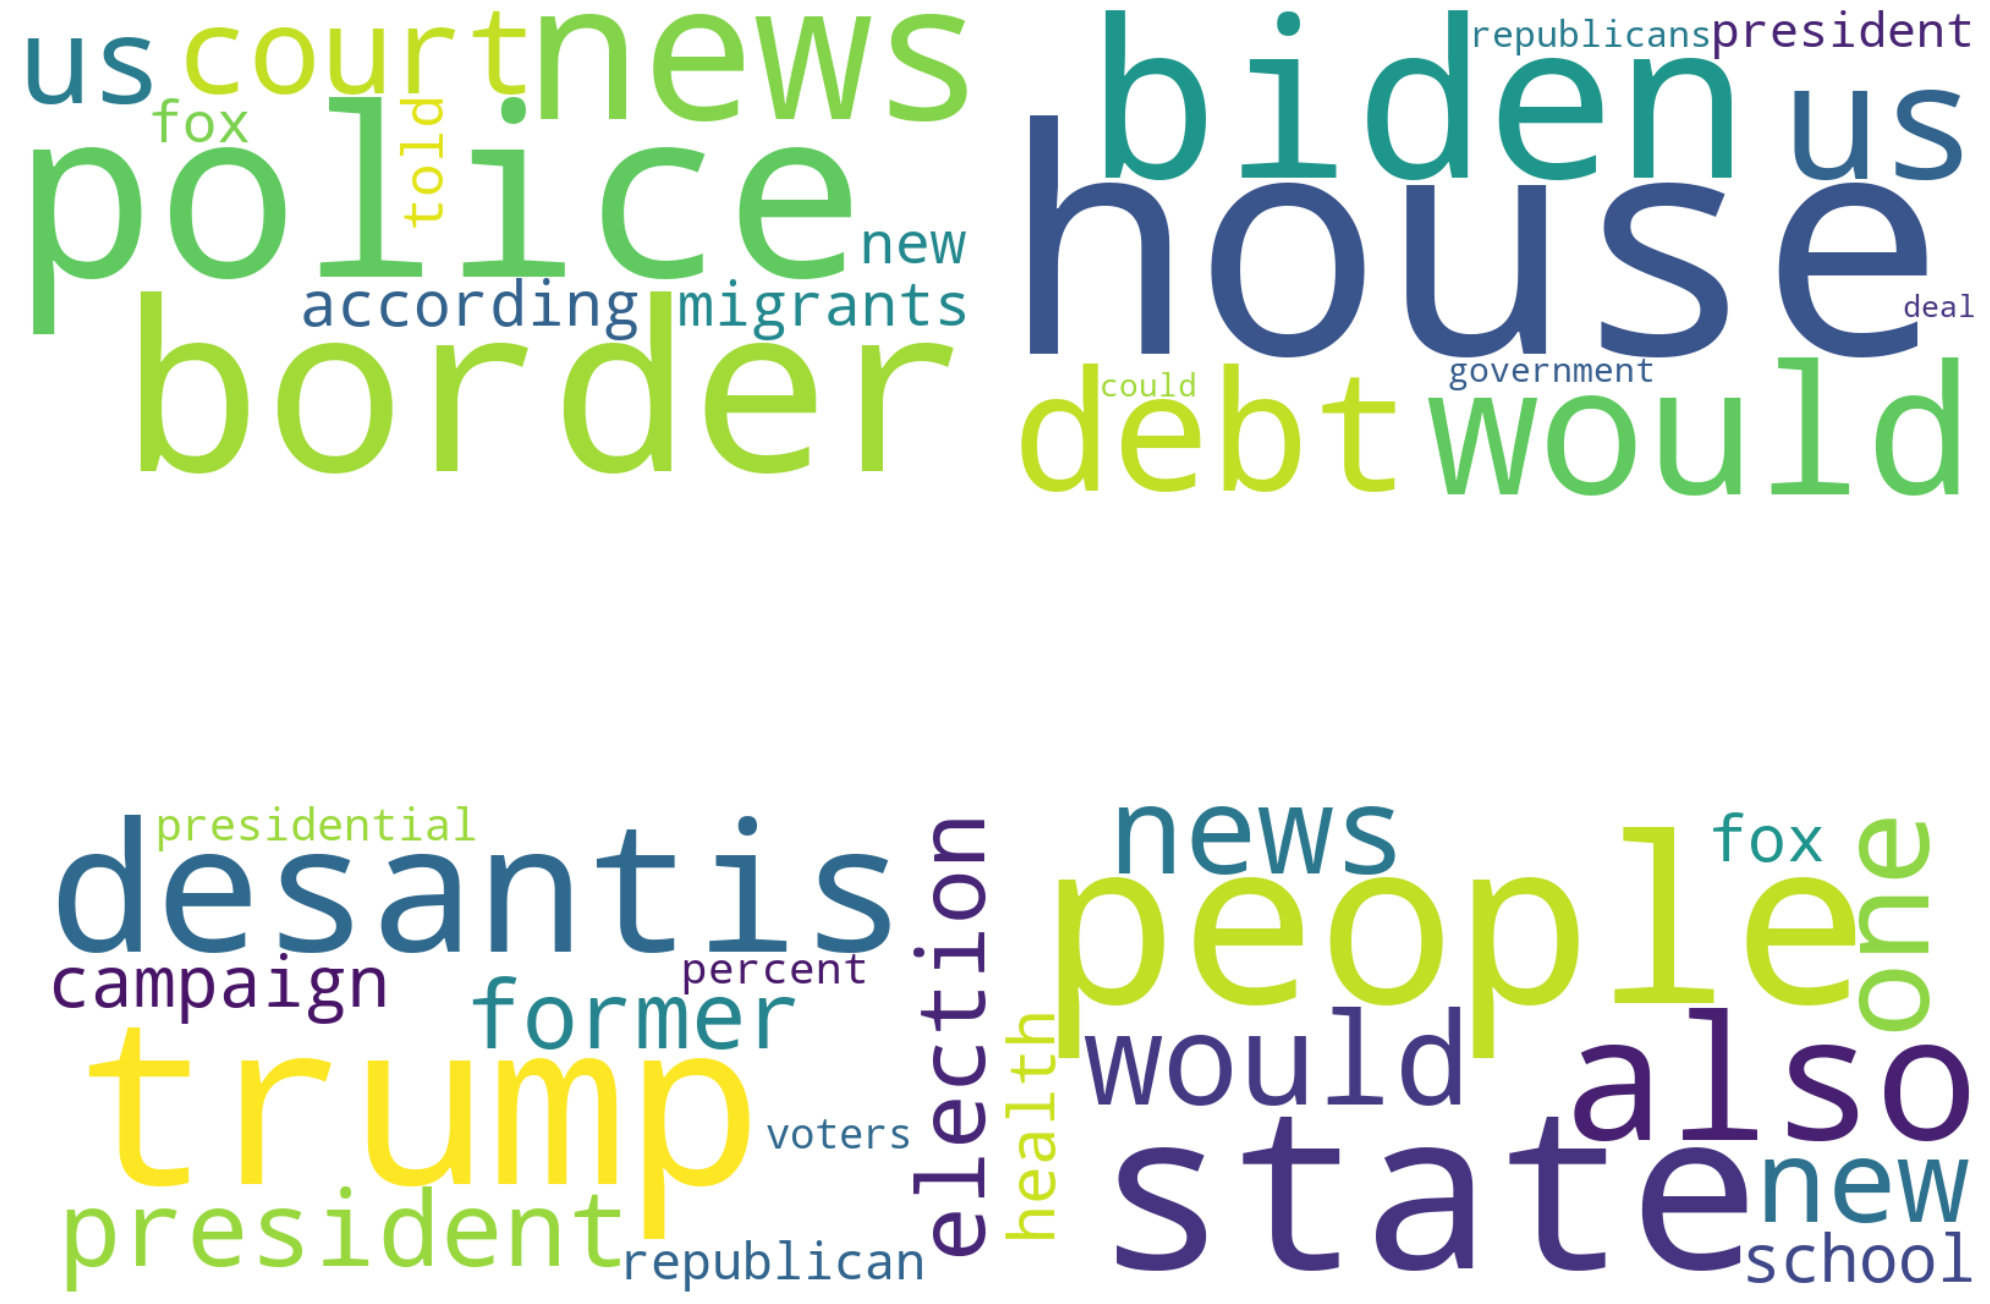

Adjusted Rand Index (ARI) comparing LDA-generated source assignments with actual sources: 0.0


In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import math

# Step 1: Vectorize your text data
count_vectorizer = CountVectorizer(min_df=0.05, max_df=0.75)
count_vectors = count_vectorizer.fit_transform(train_df['article_text_tokenized'])

# Step 2: Apply LDA to the entire dataset, with the number of topics ideally equal to the number of unique sources
n_sources = train_df['source_name'].nunique()
lda_model = LatentDirichletAllocation(n_components=n_sources, random_state=42)
lda_output = lda_model.fit_transform(count_vectors)  # shape: (n_documents, n_topics)

# Now plot
num_topics = lda_model.components_.shape[0]
words = count_vectorizer.get_feature_names_out()

# Determine grid size
grid_size = math.ceil(math.sqrt(num_topics))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))

# Ensure 1-D array to easily index into subplot grid
axs = axs.flatten()

for topic_idx, topic in enumerate(lda_model.components_):
    # Create dataframe for the current topic and sort by importance
    topic_df = pd.DataFrame({'word': words, 'importance': topic})
    topic_df = topic_df.sort_values('importance', ascending=False)

    # Get the top 5 words of the topic and create a word cloud
    top_words_dict = {row['word']: row['importance'] for idx, row in topic_df.head(10).iterrows()}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict)

    axs[topic_idx].imshow(wordcloud, interpolation='bilinear')
    axs[topic_idx].axis('off')

# Turn off unused subplots
for idx in range(num_topics, len(axs)):
    axs[idx].axis('off')

plt.tight_layout()
plt.show()

# Assign each document to the topic that has the highest probability for this document
topic_assignments = lda_output.argmax(axis=1)  # shape: (n_documents,)

# Find the optimal match between topics and source names and compute the Adjusted Rand Index
assigned_sources = []
for topic_idx in range(n_sources):
    docs_in_topic = train_df[topic_assignments == topic_idx]
    most_common_source = docs_in_topic['source_name'].mode()[0]  # the source that appears most frequently
    assigned_sources.append(most_common_source)

# Now map the topic assignments to these assigned sources
lda_generated_sources = np.array([assigned_sources[i] for i in topic_assignments])

# Compare LDA-generated source assignments with actual sources using Adjusted Rand Index (ARI)
ari = adjusted_rand_score(train_df['source_name'], lda_generated_sources)
print(f'Adjusted Rand Index (ARI) comparing LDA-generated source assignments with actual sources: {ari}')


## Text Summarization and Sentiment Analysis

In [62]:
# NLTK opinion lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

In [77]:
# List of "assumed" political phrases
political_phrases = ['gun rights', 'voting rights', 'climate change', 'immigration reform',
                     'tax cuts', 'universal healthcare',
                     'criminal justice reform', 'income inequality']

In [78]:
# Group train_df by 'source_name' for source-level comparison
grouped_df = train_df.groupby('source_name')

# Instantiate BERT pipeline
nlp = tpipeline('sentiment-analysis')

# Create dictionaries for scores
political_phrase_scores = {}
sentiment_scores = {}
sentiment_scores_T = {}

# Iterate over sources and calc TF-IDF scores vs. political phrases
for source, group in tqdm(grouped_df):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))
    tfidf_vectors = tfidf_vectorizer.fit_transform(group['article_text_tokenized'])

    # Calc TF-IDF sum (scores) where political phrases found
    scores = {}
    sentiment = defaultdict(lambda: defaultdict(int))
    sentiment_T = defaultdict(lambda: defaultdict(int))

    # Iterate over political phrases
    for phrase in political_phrases:
        try:
            index = tfidf_vectorizer.get_feature_names_out().tolist().index(phrase)  # try to find political phrase
            scores[phrase] = tfidf_vectors[:, index].sum()  # and sum related score
        except ValueError:
            pass  # didn't find political phrase

        # Iterate over each article in the group to calc sentiment
        for i in group.index:
            tokenized_text = group.loc[i, 'article_text_tokenized']
            original_text = group.loc[i, 'article_text']

            # Tokenize text into sentences because we're calc'ing sentiment on phrase-relevant sentence
            sentences = sent_tokenize(tokenized_text)

            # Check each sentence if it contains the political phrase
            for sentence in sentences:
                if phrase in sentence:
                    # [Tokenize the sentence into words
                    tokens = word_tokenize(sentence)

                    # Count positive and negative words
                    for word in tokens:
                        if word in positive_words:
                            sentiment[phrase]['positive'] += 1
                        elif word in negative_words:
                            sentiment[phrase]['negative'] += 1

                    # Now use original text (not tokenized) for BERT
                    original_sentences = sent_tokenize(original_text)
                    for original_sentence in original_sentences:
                        if phrase in original_sentence:
                            # Limit sentence to first 512 tokens for BERT
                            bert_sentence = ' '.join(word_tokenize(original_sentence)[:512])

                            # Get sentiment using BERT
                            result = nlp(bert_sentence)[0]
                            sentiment_T[phrase][result['label'].lower()] += 1
        
    # Add the scores to the dictionary
    political_phrase_scores[source] = scores
    sentiment_scores[source] = dict(sentiment)
    sentiment_scores_T[source] = dict(sentiment_T)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
100%|█████████████████████████████████████████████| 4/4 [01:08<00:00, 17.19s/it]


In [79]:
# Calc aggregate scores against which to compare "hits" above
all_scores = np.asarray(tfidf_vectors.sum(axis=0)).flatten()
mean_score = np.mean(all_scores)
median_score = np.median(all_scores)

results_df = pd.DataFrame()

# Iterate over sources and political phrase TF-IDF scores and show results
for source_name in political_phrase_scores:
    print(f'\nScores for {source_name}:')
    phrase_scores = political_phrase_scores[source_name]
    sentiment = sentiment_scores[source_name]
    sentiment_T = sentiment_scores_T[source_name]

    # . . . by political phrase
    results = []
    for phrase in political_phrases:
        score = phrase_scores.get(phrase, 0)
        relative_to_mean = score / mean_score if mean_score != 0 else 0
        relative_to_median = score / median_score if median_score != 0 else 0

        # Categorize based on relative_to_median (otherwise arbitrary)
        if relative_to_median > 10:
            category = 'high'
        elif 5 < relative_to_median <= 10:
            category = 'medium'
        else:
            category = 'low'

        sentiment_phrase = sentiment.get(phrase, {'positive': 0, 'negative': 0})
        sentiment_phrase_T = sentiment_T.get(phrase, {'positive': 0, 'negative': 0})
        results.append({
            'source_name': source_name,
            'phrase': phrase,
            'score': score,
            'relative_to_mean': relative_to_mean,
            'relative_to_median': relative_to_median,
            'category': category,
            'p_sentiment': sentiment_phrase['positive'],
            'p_sentiment_T': sentiment_phrase_T['positive'],
            'n_sentiment': sentiment_phrase['negative'],
            'n_sentiment_T': sentiment_phrase_T['negative'],
            'sentiment': sentiment_phrase['positive'] + (sentiment_phrase['negative'] * -1),
            'sentiment_T': sentiment_phrase_T['positive'] + (sentiment_phrase_T['negative'] * -1)
        })

    for result in results:
        result['sentiment_label'] = 'positive'\
            if result['sentiment'] > 0 else 'negative' if result['sentiment'] < 0 else 'neutral'
        result['sentiment_label_T'] = 'positive'\
            if result['sentiment_T'] > 0 else 'negative' if result['sentiment_T'] < 0 else 'neutral'
        
    # Sort results by score
    results.sort(key=lambda x: x['score'], reverse=True)

    # Print sorted results
    for result in results:
        print(f"{result['phrase']}:  {result['category']} importance ",
                  f"{result['sentiment_label']} sentiment")
        
    results_df = pd.concat([results_df, pd.DataFrame(results)])


Scores for Breitbart News:
climate change:  high importance  negative sentiment
tax cuts:  high importance  positive sentiment
gun rights:  high importance  negative sentiment
immigration reform:  high importance  positive sentiment
criminal justice reform:  low importance  negative sentiment
universal healthcare:  low importance  negative sentiment
voting rights:  low importance  neutral sentiment
income inequality:  low importance  neutral sentiment

Scores for CNN:
climate change:  high importance  negative sentiment
voting rights:  medium importance  negative sentiment
tax cuts:  medium importance  negative sentiment
criminal justice reform:  low importance  negative sentiment
gun rights:  low importance  negative sentiment
income inequality:  low importance  negative sentiment
immigration reform:  low importance  neutral sentiment
universal healthcare:  low importance  neutral sentiment

Scores for Fox News:
climate change:  high importance  negative sentiment
voting rights:  hig

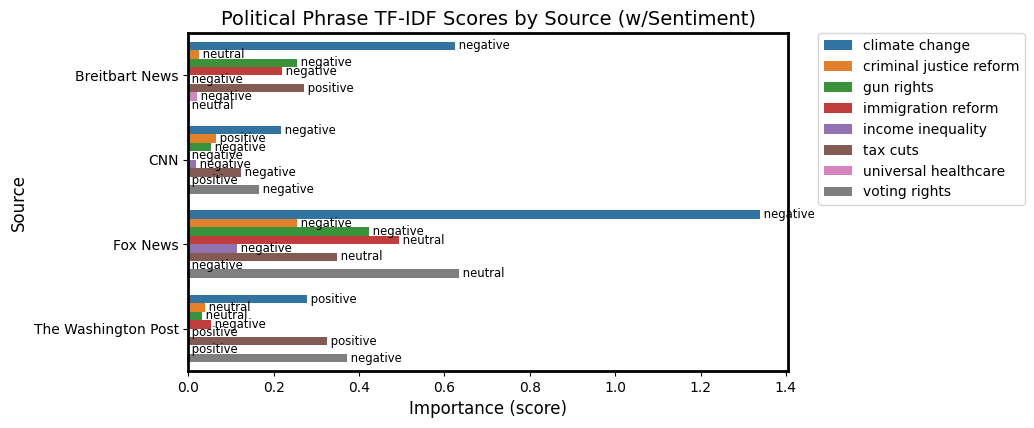

In [80]:
# Sort DataFrame by 'source' and 'phrase' to match order of bars in plot
sorted_df = results_df.sort_values(['source_name', 'phrase'])

# Create barplot
fig, ax = plt.subplots()
sns.barplot(data=sorted_df, y='source_name', x='score', 
            ax=ax, hue='phrase', errorbar=None)

# Iterate over bars and dataframe rows to add sentiment
for p, (_, row) in zip(ax.patches, sorted_df.iterrows()):
    plt.text(p.get_width(), p.get_y() + p.get_height()/2,
             f' {row["sentiment_label"]}', 
             ha='left', va='center', fontsize='smaller')

ax.set_title('Political Phrase TF-IDF Scores by Source (w/Sentiment)')
ax.set_xlabel('Importance (score)')
ax.set_ylabel('Source')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

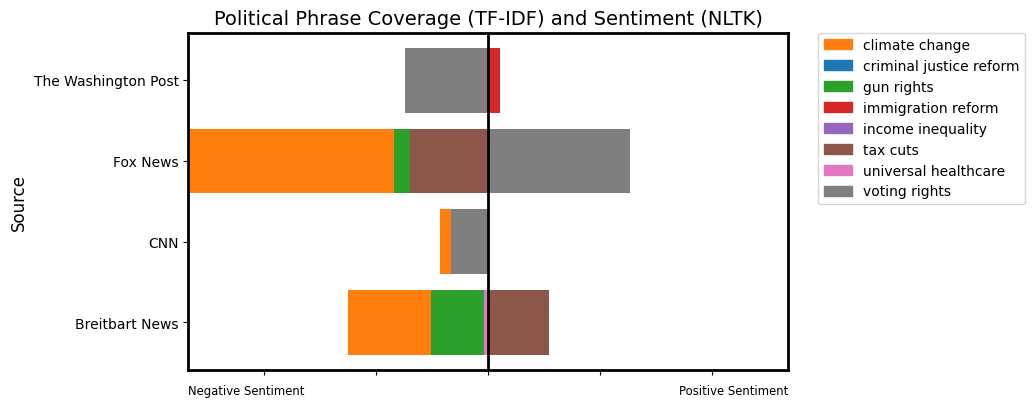

In [81]:
# Sort DataFrame by 'source' and 'phrase' to match order of bars in plot
sorted_df = results_df.sort_values(['source_name', 'phrase'])

# Create plot
fig, ax = plt.subplots()



# Define a custom color palette
custom_palette = ['#FF7F0E', '#1F77B4', '#2CA02C', '#D62728', '#9467BD',
                  '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']





# Ensure the colors are consistent
hue_order = sorted_df['phrase'].unique()
palette = [custom_palette[i % len(custom_palette)] for i in range(len(hue_order))]
#palette = sns.color_palette('husl', len(hue_order))

# List to store the created patches
patches = []

# Iterate over dataframe rows to add bars
for i, (_, row) in enumerate(sorted_df.iterrows()):
    # Adjust score so that 'negative' sentiments display to the left of the y-axis
    score = row['score'] if row['sentiment_label'] != 'negative' else row['score'] * -1

    color = palette[np.where(hue_order == row['phrase'])[0][0]]
    patch = ax.barh(row['source_name'], score, color=color)
    patches.append(patch)

ax.set_title('Political Phrase Coverage (TF-IDF) and Sentiment (NLTK)')
ax.set_ylabel('Source')

# Create a legend
handles = [plt.Rectangle((0,0),1,1, color=palette[i]) for i in range(len(hue_order))]
plt.legend(handles, hue_order, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# Center the x-axis
max_abs_score = abs(sorted_df['score']).max()
ax.set_xlim([-max_abs_score, max_abs_score])
ax.axvline(0, color='black')  # draw y-axis line

# Remove x-axis labels and add custom labels
ax.xaxis.set_ticklabels([])

ax.annotate('Negative Sentiment', xy=(-max_abs_score, 0), xytext=(0,-10), 
            xycoords=('data', 'axes fraction'), textcoords='offset points', 
            ha='left', va='top', fontsize='smaller')

ax.annotate('Positive Sentiment', xy=(max_abs_score, 0), xytext=(0,-10), 
            xycoords=('data', 'axes fraction'), textcoords='offset points', 
            ha='right', va='top', fontsize='smaller')

plt.show()


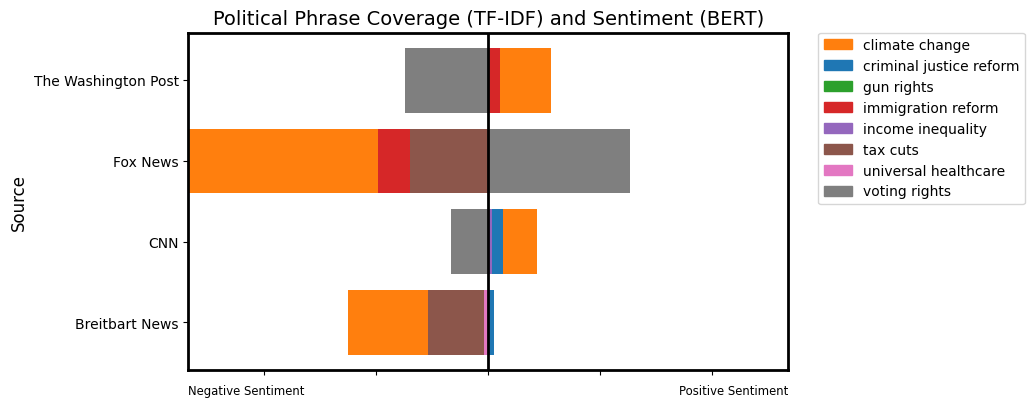

In [82]:
# Sort DataFrame by 'source' and 'phrase' to match order of bars in plot
sorted_df = results_df.sort_values(['source_name', 'phrase'])

# Create plot
fig, ax = plt.subplots()



# Define a custom color palette
custom_palette = ['#FF7F0E', '#1F77B4', '#2CA02C', '#D62728', '#9467BD',
                  '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']






# Ensure the colors are consistent
hue_order = sorted_df['phrase'].unique()
palette = [custom_palette[i % len(custom_palette)] for i in range(len(hue_order))]
#palette = sns.color_palette('husl', len(hue_order))

# List to store the created patches
patches = []

# Iterate over dataframe rows to add bars
for i, (_, row) in enumerate(sorted_df.iterrows()):
    # Adjust score so that 'negative' sentiments display to the left of the y-axis
    score = row['score'] if row['sentiment_label_T'] != 'negative' else row['score'] * -1

    color = palette[np.where(hue_order == row['phrase'])[0][0]]
    patch = ax.barh(row['source_name'], score, color=color)
    patches.append(patch)

ax.set_title('Political Phrase Coverage (TF-IDF) and Sentiment (BERT)')
ax.set_ylabel('Source')

# Create a legend
handles = [plt.Rectangle((0,0),1,1, color=palette[i]) for i in range(len(hue_order))]
plt.legend(handles, hue_order, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Center the x-axis
max_abs_score = abs(sorted_df['score']).max()
ax.set_xlim([-max_abs_score, max_abs_score])
ax.axvline(0, color='black')  # draw y-axis line

# Remove x-axis labels and add custom labels
ax.xaxis.set_ticklabels([])

ax.annotate('Negative Sentiment', xy=(-max_abs_score, 0), xytext=(0,-10), 
            xycoords=('data', 'axes fraction'), textcoords='offset points', 
            ha='left', va='top', fontsize='smaller')

ax.annotate('Positive Sentiment', xy=(max_abs_score, 0), xytext=(0,-10), 
            xycoords=('data', 'axes fraction'), textcoords='offset points', 
            ha='right', va='top', fontsize='smaller')

plt.show()


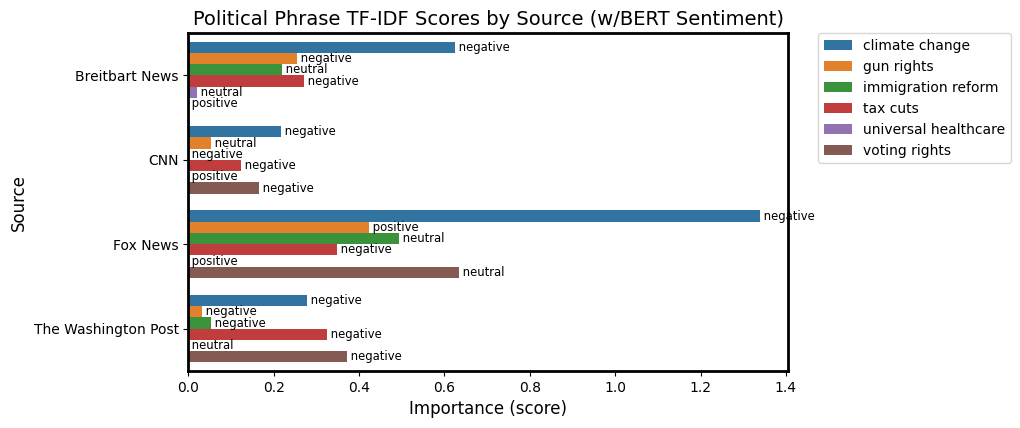

In [22]:
# Sort DataFrame by 'source' and 'phrase' to match order of bars in plot
sorted_df = results_df.sort_values(['source_name', 'phrase'])

# Create barplot
fig, ax = plt.subplots()
sns.barplot(data=sorted_df, y='source_name', x='score', 
            ax=ax, hue='phrase', errorbar=None)

# Iterate over bars and dataframe rows to add sentiment
for p, (_, row) in zip(ax.patches, sorted_df.iterrows()):
    plt.text(p.get_width(), p.get_y() + p.get_height()/2,
             f' {row["sentiment_label_T"]}', 
             ha='left', va='center', fontsize='smaller')

ax.set_title('Political Phrase TF-IDF Scores by Source (w/BERT Sentiment)')
ax.set_xlabel('Importance (score)')
ax.set_ylabel('Source')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

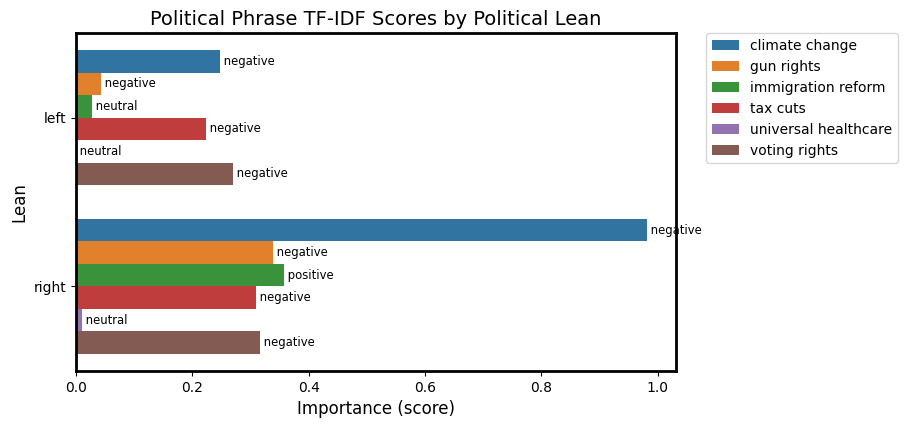

In [23]:
# Sort DataFrame by political 'lean' and 'phrase' to match order of bars in plot
lean_df = train_df[['source_name', 'lean']].drop_duplicates()
results_df = pd.merge(results_df, lean_df, on='source_name', how='left')
sorted_df = results_df.sort_values(['lean', 'phrase'])

# Create barplot
fig, ax = plt.subplots()
sns.barplot(data=sorted_df, y='lean', x='score', 
            ax=ax, hue='phrase', errorbar=None)

# Iterate over bars and dataframe rows to add sentiment
for p, (_, row) in zip(ax.patches, sorted_df.iterrows()):
    plt.text(p.get_width(), p.get_y() + p.get_height()/2,
             f' {row["sentiment_label"]}', 
             ha='left', va='center', fontsize='smaller')

ax.set_title('Political Phrase TF-IDF Scores by Political Lean')
ax.set_xlabel('Importance (score)')
ax.set_ylabel('Lean')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

## Modeling

In [24]:
import warnings
warnings.filterwarnings('ignore')

# Define labels
target_labels = master_df[target_cls_col].unique().tolist()

# Dummy function to leverage existing tokenization; and tokenize
def identity_tokenizer(tokens):
    return tokens
tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, preprocessor=lambda x: x,
                                   lowercase=False, ngram_range=(1, 3))

# Define train/val/test per original split
X_train = tfidf_vectorizer.fit_transform(train_df['article_text_tokenized'])
y_train = train_df[target_cls_col]
X_val = tfidf_vectorizer.transform(val_df['article_text_tokenized'])
y_val = val_df[target_cls_col]
X_test = tfidf_vectorizer.transform(test_df['article_text_tokenized'])
y_test = test_df[target_cls_col]

# Finally, convert sparse matrices to dataframes as required by ModelProcess class
X_train = pd.DataFrame.sparse.from_spmatrix(X_train, columns=tfidf_vectorizer.get_feature_names_out())
X_val = pd.DataFrame.sparse.from_spmatrix(X_val, columns=tfidf_vectorizer.get_feature_names_out())
X_test = pd.DataFrame.sparse.from_spmatrix(X_test, columns=tfidf_vectorizer.get_feature_names_out())

In [55]:
# Set model list
mp_queue = (
#    (LogisticRegression(), {'C': 0.01, 'class_weight': 'balanced', 'random_state': 42}),
    (NearestCentroid(), {}),
)

In [56]:
import copy

ModelProcess.show_progress = True

# Iterate models (note use of 'copy' is to preserve mutable elements
#   of model_queue tuple for possible later use)
mp_df = pd.DataFrame(mp_queue, columns=['algorithm', 'params'])
mp_df['mp'] = mp_df.apply(
    lambda mp: ModelProcess(copy.deepcopy(mp['algorithm']), None,
                            copy.copy(mp['params']),
                            X_train, y_train,
                            X_val, y_val,
                            X_test, y_test,
                            labels=target_labels,
                            cat_cols=None, num_cols=None,
                            balance_target=True).train_validate_test(), axis=1)

# Compile, sort, and display results
mp_df[['train_acc', 'train_f1', 'train_time',
       'val_acc', 'val_f1', 'val_time',
       'test_acc', 'test_f1', 'test_time']] =\
    mp_df['mp'].apply(
        lambda mp: sum(list(map(
            lambda dataset: mp.score[dataset] + [mp.time[dataset]], ['train', 'val', 'test'])), [])).tolist()
mp_df.sort_values(by=['train_f1', 'val_f1', 'test_f1'],
                  ascending=[False, False, False], inplace=True)
mp_df.loc[:, mp_df.columns != 'mp'].to_csv('results_table.csv')

print()
mp_df

NearestCentroid: train... done in 4.77s.
NearestCentroid: val... done in 0.69s.
NearestCentroid: test... done in 0.45s.



,algorithm,params,mp,train_acc,train_f1,train_time,val_acc,val_f1,val_time,test_acc,test_f1,test_time
0,NearestCentroid(),{},<model_process.ModelProcess object at 0x7f8276...,0.84,0.76,4.77,0.83,0.75,0.69,0.84,0.77,0.45


In [27]:
# Select model (process) for focus and tuning
select_mp = 1

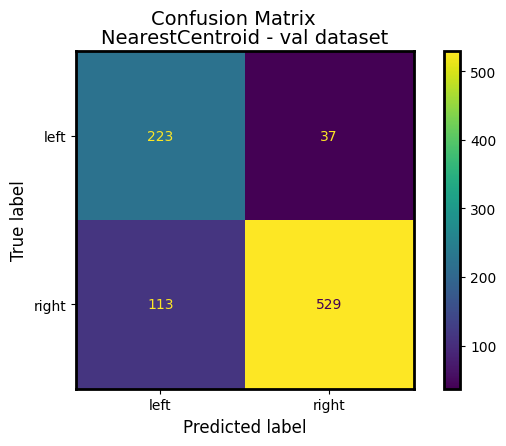



NearestCentroid - val dataset

              precision    recall  f1-score   support

        left       0.66      0.86      0.75       260
       right       0.93      0.82      0.88       642

    accuracy                           0.83       902
   macro avg       0.80      0.84      0.81       902
weighted avg       0.86      0.83      0.84       902



In [28]:
# Show confusion matrix and summary for top Neural Network
mp_df.loc[select_mp]['mp'].confusion_matrix('val')
mp_df.loc[select_mp]['mp'].summary('val')